# In Depth A/B Testing - Lab

## Introduction

In this lab, you'll explore a survey from Kaggle regarding budding data scientists. With this, you'll form some initial hypotheses, and test them using the tools you've acquired to date. 

## Objectives

You will be able to:
* Conduct t-tests and an ANOVA on a real-world dataset and interpret the results

## Load the Dataset and Perform a Brief Exploration

The data is stored in a file called **multipleChoiceResponses_cleaned.csv**. Feel free to check out the original dataset referenced at the bottom of this lab, although this cleaned version will undoubtedly be easier to work with. Additionally, meta-data regarding the questions is stored in a file name **schema.csv**. Load in the data itself as a Pandas DataFrame, and take a moment to briefly get acquainted with it.

> Note: If you can't get the file to load properly, try changing the encoding format as in `encoding='latin1'`

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styles
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
%matplotlib inline

from itertools import combinations

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

import warnings
warnings.filterwarnings("ignore")

from flatiron_stats import *

In [2]:
#Your code here
df = pd.read_csv('multipleChoiceResponses_cleaned.csv', encoding='latin-1')
df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity,exchangeRate,AdjustedCompensation
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,NaN,NaN
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,250000.0
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26394 entries, 0 to 26393
Columns: 230 entries, GenderSelect to AdjustedCompensation
dtypes: float64(15), object(215)
memory usage: 46.3+ MB


In [4]:
print(df.FormalEducation.unique())
print(df.FormalEducation.nunique())
print(df.FormalEducation.isna().value_counts(normalize=True))

["Bachelor's degree" "Master's degree" 'Doctoral degree' nan
 "Some college/university study without earning a bachelor's degree"
 'I did not complete any formal education past high school'
 'Professional degree' 'I prefer not to answer']
7
False    0.687353
True     0.312647
Name: FormalEducation, dtype: float64


In [5]:
print(df.AdjustedCompensation.unique())
print(df.AdjustedCompensation.nunique())
print(df.AdjustedCompensation.isna().value_counts(normalize=True))

[        nan 2.50000e+05 6.41848e+04 ... 3.18780e+04 3.33600e+03
 1.00000e+00]
1627
True     0.835455
False    0.164545
Name: AdjustedCompensation, dtype: float64


In [6]:
df[~df.FormalEducation.isna()].FormalEducation.isna().value_counts(normalize=True)

False    1.0
Name: FormalEducation, dtype: float64

In [7]:
df[~df.AdjustedCompensation.isna()].AdjustedCompensation.isna().value_counts(normalize=True)

False    1.0
Name: AdjustedCompensation, dtype: float64

In [8]:
sel_df = df[(~df.FormalEducation.isna()) & (~df.AdjustedCompensation.isna())]
print(sel_df.FormalEducation.isna().value_counts(normalize=True))
print(sel_df.AdjustedCompensation.isna().value_counts(normalize=True))

False    1.0
Name: FormalEducation, dtype: float64
False    1.0
Name: AdjustedCompensation, dtype: float64


## Wages and Education

You've been asked to determine whether education is impactful to salary. Develop a hypothesis test to compare the salaries of those with Master's degrees to those with Bachelor's degrees. Are the two statistically different according to your results?

> Note: The relevant features are stored in the 'FormalEducation' and 'AdjustedCompensation' features.

You may import the functions stored in the `flatiron_stats.py` file to help perform your hypothesis tests. It contains the stats functions that you previously coded: `welch_t(a,b)`, `welch_df(a, b)`, and `p_value(a, b, two_sided=False)`. 

Note that `scipy.stats.ttest_ind(a, b, equal_var=False)` performs a two-sided Welch's t-test and that p-values derived from two-sided tests are two times the p-values derived from one-sided tests. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for more information.    

In [9]:
#Your code here
sel_df_1 = sel_df[sel_df.FormalEducation == 'Master\'s degree']
sel_df_2 = sel_df[sel_df.FormalEducation == 'Bachelor\'s degree']
sel_df_3 = sel_df[sel_df.FormalEducation == 'Doctoral degree']
print(sel_df_1.FormalEducation.isna().value_counts(normalize=True))
print(sel_df_2.FormalEducation.isna().value_counts(normalize=True))
print(sel_df_3.FormalEducation.isna().value_counts(normalize=True))
print(sel_df_1.AdjustedCompensation.isna().value_counts(normalize=True))
print(sel_df_2.AdjustedCompensation.isna().value_counts(normalize=True))
print(sel_df_3.AdjustedCompensation.isna().value_counts(normalize=True))

False    1.0
Name: FormalEducation, dtype: float64
False    1.0
Name: FormalEducation, dtype: float64
False    1.0
Name: FormalEducation, dtype: float64
False    1.0
Name: AdjustedCompensation, dtype: float64
False    1.0
Name: AdjustedCompensation, dtype: float64
False    1.0
Name: AdjustedCompensation, dtype: float64


In [10]:
sel_df_1_AC = sel_df_1.AdjustedCompensation
sel_df_2_AC = sel_df_2.AdjustedCompensation
sel_df_3_AC = sel_df_3.AdjustedCompensation

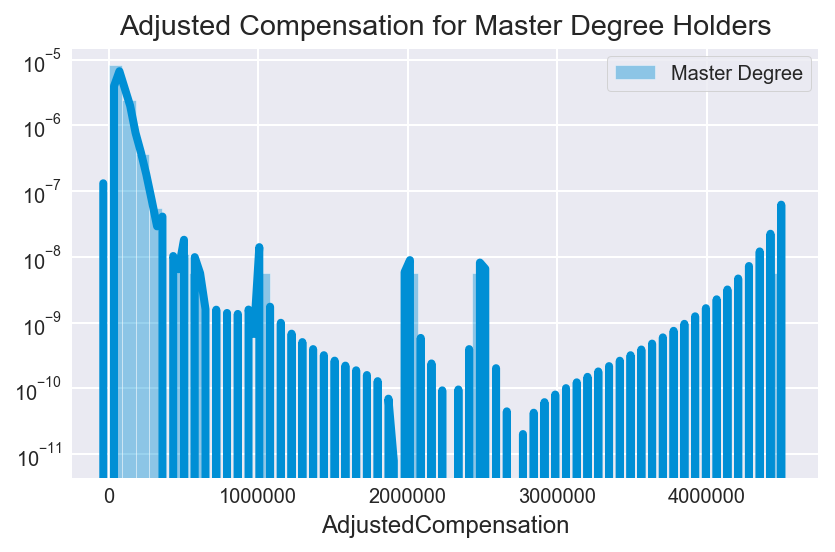

In [11]:
sns.distplot(sel_df_1_AC,label='Master Degree').set_yscale('log')
plt.title('Adjusted Compensation for Master Degree Holders')
plt.legend()

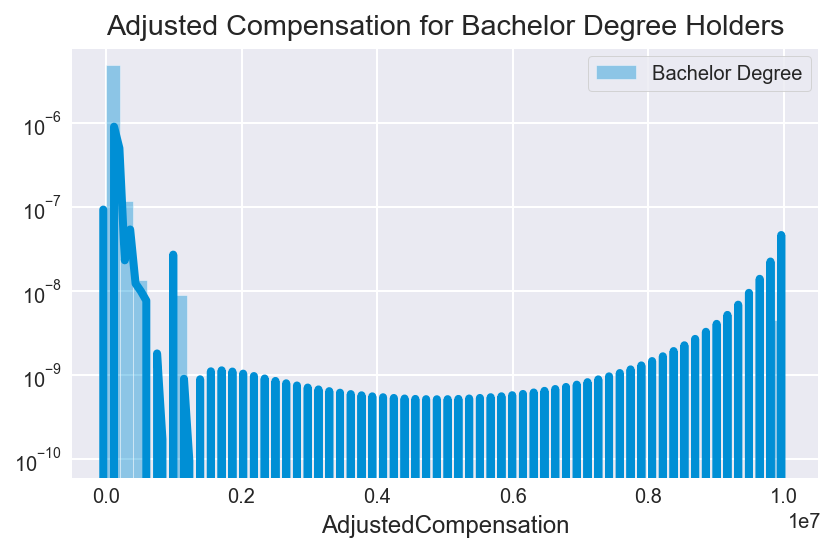

In [12]:
sns.distplot(sel_df_2_AC,label='Bachelor Degree').set_yscale('log')
plt.title('Adjusted Compensation for Bachelor Degree Holders')
plt.legend()

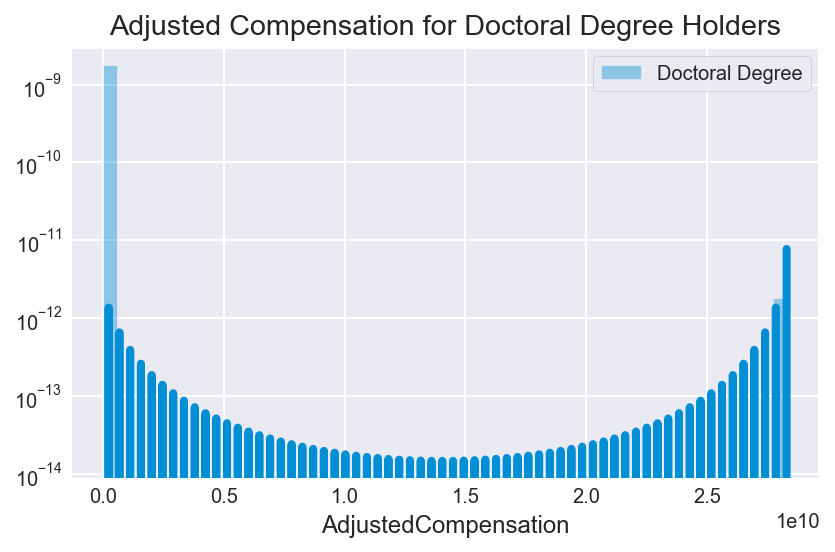

In [13]:
sns.distplot(sel_df_3_AC,label='Doctoral Degree').set_yscale('log')
plt.title('Adjusted Compensation for Doctoral Degree Holders')
plt.legend()

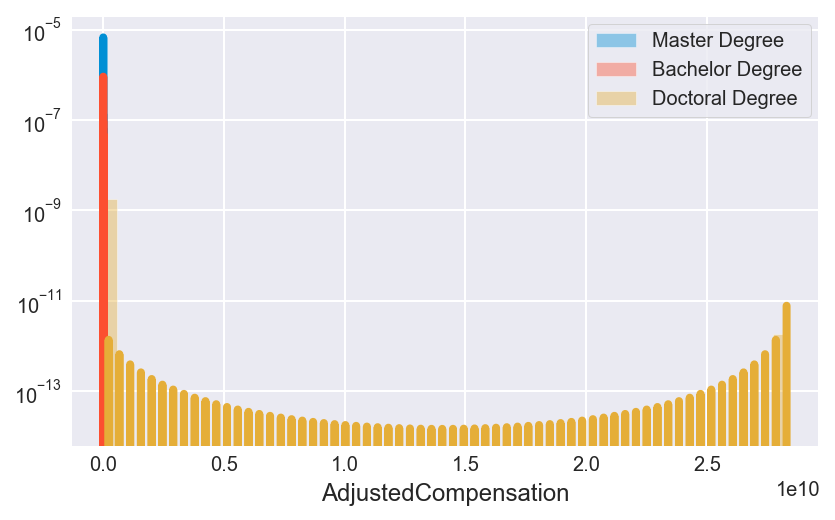

In [14]:
sns.distplot(sel_df_1_AC,label='Master Degree',hist={'alpha':0.3}).set_yscale('log')
sns.distplot(sel_df_2_AC,label='Bachelor Degree',hist={'alpha':0.3}).set_yscale('log')
sns.distplot(sel_df_3_AC,label='Doctoral Degree',hist={'alpha':0.3}).set_yscale('log')
plt.legend()

In [15]:
print('Comparison of {} for {}, {} and {}'.format('AdjustedCompensation', 'Master', 'Bachelor', 'PhD'))
print("Median Values: \ts1: {} \ts2: {} \ts3: {}".format(round(sel_df_1_AC.median(),2), round(sel_df_2_AC.median(),2), round(sel_df_3_AC.median(),2)))
print("Mean Values: \ts1: {} \ts2: {} \ts3: {}".format(round(sel_df_1_AC.mean(),2), round(sel_df_2_AC.mean(),2), round(sel_df_3_AC.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {} \ts3: {}'.format(len(sel_df_1_AC), len(sel_df_2_AC), len(sel_df_3_AC)))
print("Welch's t-test p-value (Master vs. Bachelor):", p_value_welch_ttest(sel_df_1_AC, sel_df_2_AC))
print("Welch's t-test p-value (PhD vs. Bachelor):", p_value_welch_ttest(sel_df_3_AC, sel_df_2_AC))
print("Welch's t-test p-value (Master vs. PhD):", p_value_welch_ttest(sel_df_1_AC, sel_df_3_AC))

Comparison of AdjustedCompensation for Master, Bachelor and PhD
Median Values: 	s1: 53812.17 	s2: 38399.4 	s3: 74131.92
Mean Values: 	s1: 69139.9 	s2: 64887.1 	s3: 29566175.76
Sample sizes: 	s1: 1990 	s2: 1107 	s3: 967
Welch's t-test p-value (Master vs. Bachelor): 0.33077639451272445
Welch's t-test p-value (PhD vs. Bachelor): 0.15682381994720251
Welch's t-test p-value (Master vs. PhD): 0.15685867311868817


In [16]:
#Investigate Percentiles
for q in np.linspace(.8, 1, 21):
    s1q =  round(sel_df_1_AC.quantile(q=q), 2)
    s2q =  round(sel_df_2_AC.quantile(q=q), 2)
    s3q =  round(sel_df_3_AC.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}\tset2: {}\tset3: {}'.format(round(q,2), s1q, s2q, s3q))

0.8th percentile:	set1: 103000.0	set2: 93233.13	set3: 135000.0
0.81th percentile:	set1: 107009.0	set2: 95572.83	set3: 140000.0
0.82th percentile:	set1: 110000.0	set2: 99276.38	set3: 140000.0
0.83th percentile:	set1: 111503.83	set2: 100000.0	set3: 146796.17
0.84th percentile:	set1: 115240.4	set2: 103040.0	set3: 150000.0
0.85th percentile:	set1: 119582.6	set2: 105935.04	set3: 150000.0
0.86th percentile:	set1: 120000.0	set2: 110000.0	set3: 155000.0
0.87th percentile:	set1: 124719.88	set2: 112000.0	set3: 160000.0
0.88th percentile:	set1: 129421.46	set2: 115000.0	set3: 160000.0
0.89th percentile:	set1: 130000.0	set2: 120000.0	set3: 166480.0
0.9th percentile:	set1: 135000.0	set2: 120346.5	set3: 172057.78
0.91th percentile:	set1: 140000.0	set2: 126460.0	set3: 175000.0
0.92th percentile:	set1: 149640.0	set2: 132615.4	set3: 181555.2
0.93th percentile:	set1: 150000.0	set2: 140000.0	set3: 191900.0
0.94th percentile:	set1: 160000.0	set2: 143408.8	set3: 200000.0
0.95th percentile:	set1: 166778.6	se

In [17]:
print('Repeated Test with Outliers Removed:')
print('S1: {}\tS2: {}\tS3: {}'.format('Master', 'Bachelor', 'PhD'))
outlier_threshold = 500000
sel_df_1_AC_RO = sel_df_1[sel_df_1_AC <= outlier_threshold].AdjustedCompensation
sel_df_2_AC_RO = sel_df_2[sel_df_2_AC <= outlier_threshold].AdjustedCompensation
sel_df_3_AC_RO = sel_df_3[sel_df_3_AC <= outlier_threshold].AdjustedCompensation
print("Median Values: \ts1: {} \ts2: {} \ts3: {}".format(round(sel_df_1_AC_RO.median(),2), round(sel_df_2_AC_RO.median(),2), round(sel_df_3_AC_RO.median(),2)))
print("Mean Values: \ts1: {} \ts2: {} \ts3: {}".format(round(sel_df_1_AC_RO.mean(),2), round(sel_df_2_AC_RO.mean(),2), round(sel_df_3_AC_RO.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {} \ts3: {}'.format(len(sel_df_1_AC_RO), len(sel_df_2_AC_RO), len(sel_df_3_AC_RO)))
print("Welch's t-test p-value with outliers removed (Master vs. Bachelor):", p_value_welch_ttest(sel_df_1_AC_RO, sel_df_2_AC_RO))
print("Welch's t-test p-value with outliers removed (PhD vs. Bachelor):", p_value_welch_ttest(sel_df_3_AC_RO, sel_df_2_AC_RO))
print("Welch's t-test p-value with outliers removed (Master vs. PhD):", p_value_welch_ttest(sel_df_1_AC_RO, sel_df_3_AC_RO))

Repeated Test with Outliers Removed:
S1: Master	S2: Bachelor	S3: PhD
Median Values: 	s1: 53539.72 	s2: 38292.15 	s3: 73152.77
Mean Values: 	s1: 63976.63 	s2: 53744.35 	s3: 86194.98
Sample sizes: 	s1: 1985 	s2: 1103 	s3: 964
Welch's t-test p-value with outliers removed (Master vs. Bachelor): 4.4874583271514723e-07
Welch's t-test p-value with outliers removed (PhD vs. Bachelor): 0.0
Welch's t-test p-value with outliers removed (Master vs. PhD): 0.0


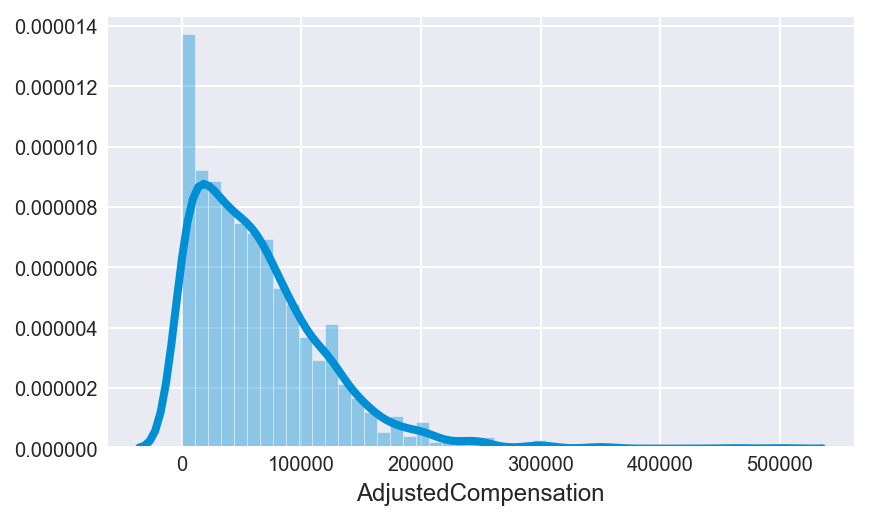

In [18]:
sns.distplot(sel_df_1_AC_RO)

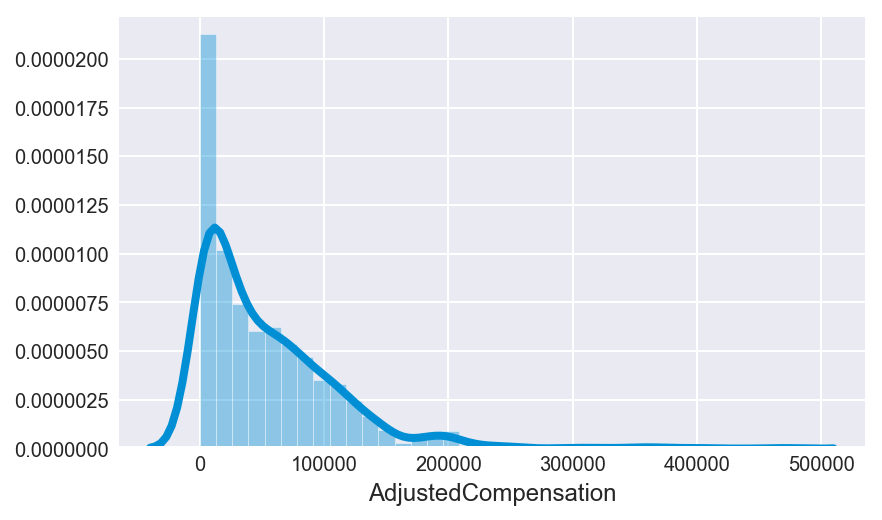

In [19]:
sns.distplot(sel_df_2_AC_RO)

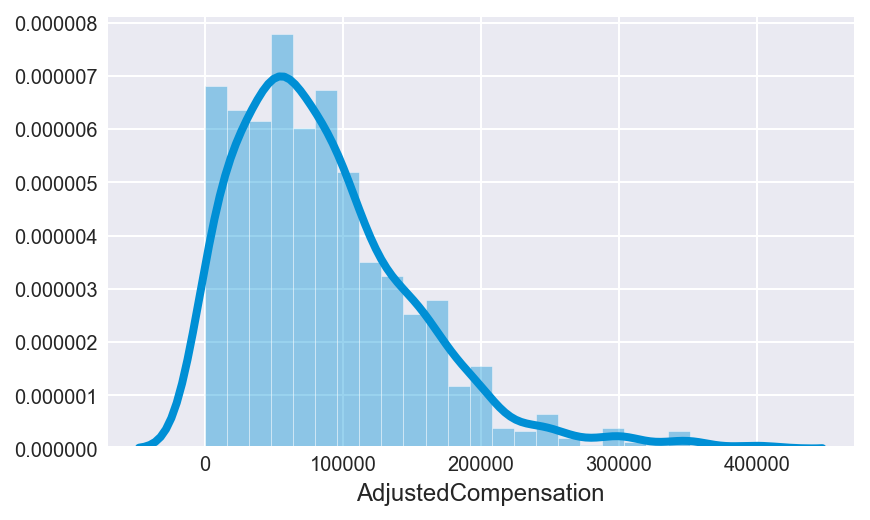

In [20]:
sns.distplot(sel_df_3_AC_RO)

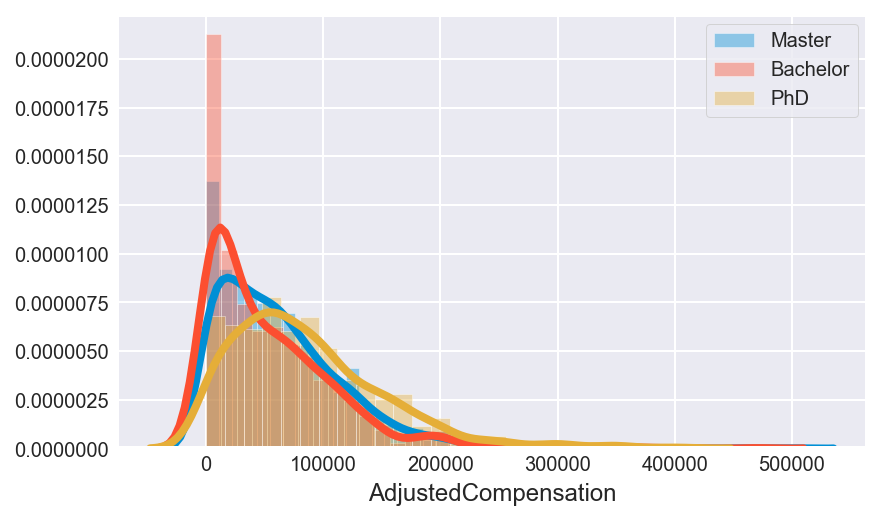

In [21]:
sns.distplot(sel_df_1_AC_RO,label='Master')
sns.distplot(sel_df_2_AC_RO,label='Bachelor')
sns.distplot(sel_df_3_AC_RO,label='PhD')
plt.legend()

## Wages and Education II

Now perform a similar statistical test comparing the AdjustedCompensation of those with Bachelor's degrees and those with Doctorates. If you haven't already, be sure to explore the distribution of the AdjustedCompensation feature for any anomalies. 

In [22]:
#Your code here
# Median Values: 
# s1:74131.92 
# s2:38399.4
# Sample sizes: 
# s1: 967 
# s2: 1107
# Welch's t-test p-value: 0.1568238199472023

# Repeated Test with Ouliers Removed:
# Sample sizes: 
# s1: 964 
# s2: 1103
# Welch's t-test p-value with outliers removed: 0.0

## Wages and Education III

Remember the multiple comparisons problem; rather than continuing on like this, perform an ANOVA test between the various 'FormalEducation' categories and their relation to 'AdjustedCompensation'.

In [23]:
#Your code here
formula = '{} ~ C({})'.format('AdjustedCompensation','FormalEducation')
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  6.540294e+17     6.0  0.590714  0.738044
Residual            7.999414e+20  4335.0       NaN       NaN


In [24]:
formula = '{} ~ C({})'.format('AdjustedCompensation','FormalEducation')
lm = ols(formula, sel_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  6.540294e+17     6.0  0.590714  0.738044
Residual            7.999414e+20  4335.0       NaN       NaN


In [25]:
sel_df_RO = df[(~df.FormalEducation.isna()) & (~df.AdjustedCompensation.isna()) & (df.AdjustedCompensation <= outlier_threshold)]

In [26]:
formula = '{} ~ C({})'.format('AdjustedCompensation','FormalEducation')
lm = ols(formula, sel_df_RO).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df          F        PR(>F)
C(FormalEducation)  5.841881e+11     6.0  29.224224  1.727132e-34
Residual            1.439270e+13  4320.0        NaN           NaN


## Additional Resources

Here's the original source where the data was taken from:  
    [Kaggle Machine Learning & Data Science Survey 2017](https://www.kaggle.com/kaggle/kaggle-survey-2017)

## Summary

In this lab, you practiced conducting actual hypothesis tests on actual data. From this, you saw how dependent results can be on the initial problem formulation, including preprocessing!